# 1. test interpolation

In [1]:
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def plot(xs, ts, x, t):
    dt = t[1] - t[0]
    v = np.gradient(x) / dt
    a = np.gradient(v) / dt
    fig, axes = plt.subplots(3, 1)
    axes[0].plot(ts, xs, 'o')
    axes[0].plot(t, x, 'r')
    axes[1].plot(t, v)
    axes[2].plot(t, a)
    axes[0].set_title('x(t)')
    axes[1].set_title('v(t)')
    axes[2].set_title('a(t)')
    plt.show()

In [3]:
n = 10
mag = 5
xs = (np.random.rand(n) - 0.5) * 2 * mag
ts = np.linspace(0, 1, n)
t = np.linspace(0, 1, n*100)

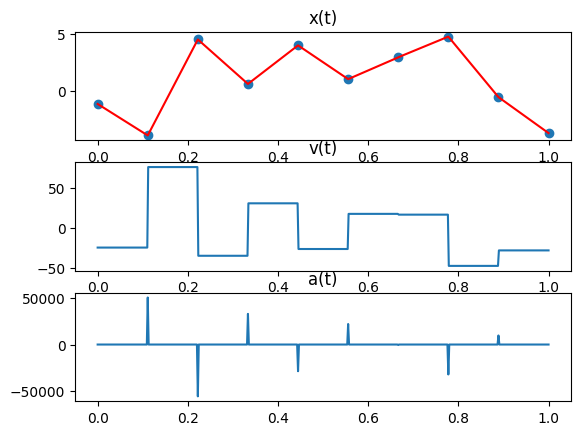

In [4]:
f = interp1d(ts, xs, kind='linear')
x = f(t)
plot(xs, ts, x, t)

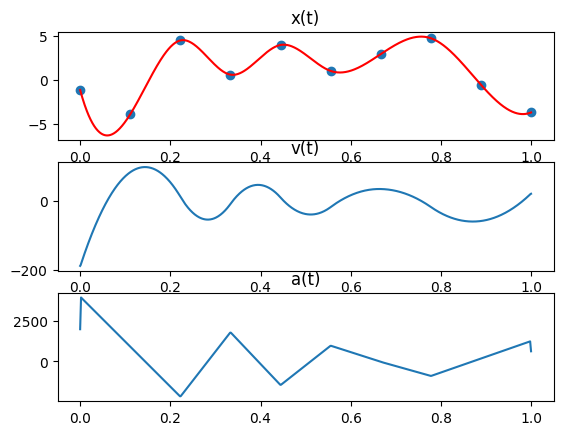

In [5]:
f = interp1d(ts, xs, kind='cubic')
x = f(t)
plot(xs, ts, x, t)

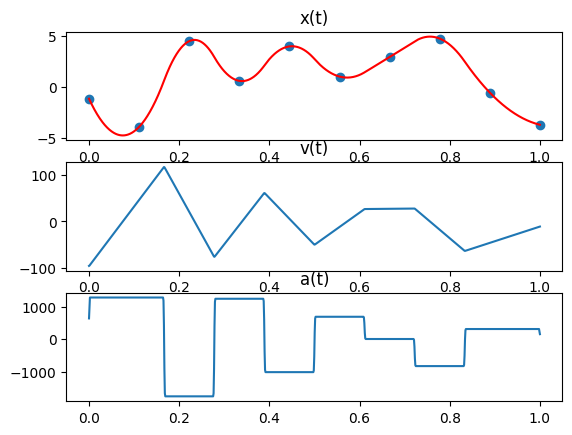

In [6]:
f = interp1d(ts, xs, kind='quadratic')
x = f(t)
plot(xs, ts, x, t)

| interpolate type | function | first derivative | second derivative |
|------------|--------------|----------------|----------------|
| linear     | continuous   | non-continuous | non-continuous |
| quadratic  | continuous   | continuous     | non-continuous |
| cubic      | continuous   | continuous     | continuous     |

# 2. Test PyPose
## 2.1. Generate ground truths

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
from scipy.interpolate import interp1d

import torch
import pypose as pp
import matplotlib.pyplot as plt


In [8]:
# si1 = si + vi*dt + 0.5*ai*dt^2, ai = (vi1 - vi) / dt
# si1 = si + (vi + vi1)/2 * dt
# va is an implementation that match pypose 
# va2 is a simple numerical differentiation
def va(pos, dt):
    v = np.zeros((len(pos), 3))
    v_avg = (pos[1:] - pos[:-1]) / dt
    v[0] = (3*v_avg[0] - v_avg[1]) / 2 - 0.1
    for i in range(1, len(pos)-1):
        v[i] = 2*v_avg[i-1] - v[i-1]
    a = (v[1:] - v[:-1]) / dt
    return v, a

def va2(pos, dt):
    v = np.diff(pos, axis=0, prepend=pos[:1]) / dt
    a = np.diff(v, axis=0) / dt
    return v, a

In [9]:
rendering_dt = 1.0/10
physics_dt = 1.0/100
pi = np.pi
g=9.81
# time stamps
T = 10
ts = np.arange(0, T, rendering_dt)
t = np.arange(0, ts[-1], physics_dt)
# positions
points = np.random.rand(int(T / rendering_dt), 3)
f = interp1d(ts, points, kind='cubic', axis=0)
translations = f(t)
# orientations
angles = np.random.rand(int(T / rendering_dt), 3)
angles = (angles - 0.5) * 2 * np.pi
angles[0, :] = 0
# angles = np.zeros((len(ts), 3))
rs = R.from_euler('xyz', angles, degrees=False) # extrinsic
f = Slerp(ts, rs)
rots = f(t)
rots_inv = rots.inv()
quats_xyzw = rots.as_quat()
quats_wxyz = np.roll(quats_xyzw, 1, axis=1)
# linear velocities & accelerations
velocities, acceleration = va2(translations, physics_dt)
acceleration_g = acceleration + np.array([0, 0, g])
acceleration_imu = np.array([r@a for r, a in zip(rots_inv[:-1].as_matrix(), acceleration_g)])
# angular velocities
rots_diff = rots_inv[:-1] * rots[1:]
rots_diff = rots_diff.as_rotvec()
angular_velocities = rots_diff / physics_dt


data = {
    "init_pos": translations[0],
    "init_rot": quats_wxyz[0],
    "init_vel": velocities[0],
    "gt_pos": translations[1:],
    "gt_rot": quats_wxyz[1:],
    "gt_vel": velocities[1:],
    "accel": acceleration_imu,
    "gyro": angular_velocities,
    "dt": np.array([physics_dt]*len(acceleration_imu))
}

assert len(data['accel']) == len(data['gyro']) == len(data['dt']) == len(data['gt_rot']) == len(data['gt_pos']) == len(data['gt_vel'])

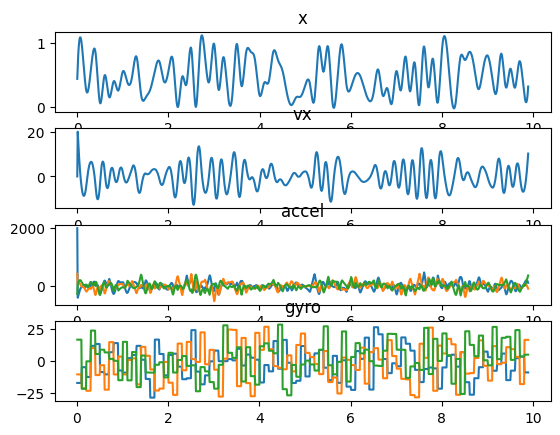

In [10]:
plt.subplot(4, 1, 1)
plt.title('x')
plt.plot(t, translations[:,0])
plt.subplot(4, 1, 2)
plt.title('vx')
plt.plot(t, velocities[:,0])
plt.subplot(4, 1, 3)
plt.title('accel')
plt.plot(t[1:], acceleration_imu)
plt.subplot(4, 1, 4)
plt.title('gyro')
plt.plot(t[1:], angular_velocities)

## 2.2. Preintegration with PyPose

dt: torch.Size([1, 989, 1]), gyro: torch.Size([1, 989, 3]), acc: torch.Size([1, 989, 3])
dr: torch.Size([1, 989, 4]), w: torch.Size([1, 990, 4]), incre_r: torch.Size([1, 990, 4])


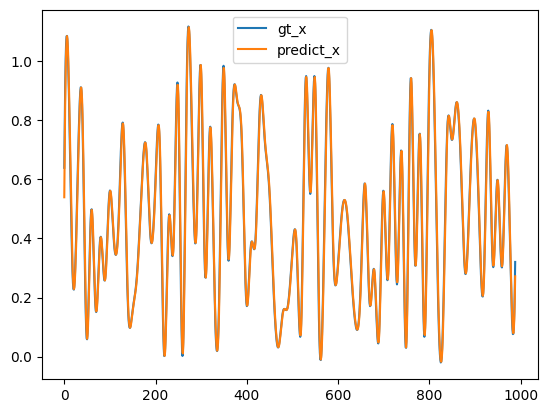

In [11]:
init_state = {
    'pos':torch.Tensor(translations[0]), 
    'rot':pp.SO3(quats_xyzw[0]), 
    'vel':torch.Tensor(velocities[0])
}

integrator = pp.module.IMUPreintegrator(
    **init_state,
    gravity=g,
    gyro_cov=0.0,
    acc_cov=0.0
)

predict_state = integrator(
    dt = torch.Tensor(data["dt"]).unsqueeze(1),
    gyro = torch.Tensor(data['gyro']),
    acc = torch.Tensor(data['accel']),
)

predict_pos = predict_state['pos'][0].numpy()
plt.plot(translations[1:,0], label='gt_x')
plt.plot(predict_pos[:, 0], label='predict_x')
plt.legend()


# 3. testing with ISAAC

In [12]:
#to disable isaac startup logs
import sys
import os
import signal

from isaacsim import SimulationApp

CONFIG = {
    'headless': False,
    'display_options': 3286
}

simulation_app = SimulationApp(CONFIG)
simulation_app.update()

spinning = True
def sigint_handler(sig, frame):
    global spinning
    spinning = False
signal.signal(signal.SIGINT, sigint_handler)

kernel = get_ipython().kernel
kernel.pre_handler_hook = lambda: None
kernel.post_handler_hook = lambda: None

def spin(update_function, *args, **kwargs):
    global spinning
    print('gui can be used now. interrupt kernel to go back to notebook')
    while spinning:
        update_function(*args, **kwargs)
    spinning = True

def resume_gui():
    spin(lambda: simulation_app.update())
    
print(os.getcwd())

Starting kit application with the following args:  ['/f/ov/pkg/isaac-sim-4.1.0/exts/omni.isaac.kit/omni/isaac/kit/simulation_app.py', '/f/ov/pkg/isaac-sim-4.1.0/apps/omni.isaac.sim.python.kit', '--/app/tokens/exe-path=/f/ov/pkg/isaac-sim-4.1.0/kit', '--/persistent/app/viewport/displayOptions=3286', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/exts', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/apps', '--/physics/cudaDevice=0', '--portable']
Passing the following args to the base kit application:  ['-f', '/home/linh/.local/share/jupyter/runtime/kernel-a7610bc3-17ac-44a6-a241-3e318317debc.json']
[Warning] [omni.isaac.kit.simulation_app] Non-headless mode not supported with jupyt

Warp 1.2.1 initialized:
   CUDA Toolkit 11.8, Driver 12.5
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 4060" (8 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/linh/.cache/warp/1.2.1
[ext: omni.kit.widget.text_editor-1.0.2] startup
[2.997s] [ext: omni.kit.viewport.window-106.0.8] startup
[3.019s] [ext: omni.kit.window.property-1.11.1] startup
[3.021s] [ext: omni.usdphysics-106.0.20] startup
[3.027s] [ext: omni.graph.tools-1.78.0] startup
[3.051s] [ext: omni.kit.viewport.utility-1.0.17] startup
[3.051s] [ext: omni.kit.property.usd-3.21.28] startup
[3.061s] [ext: omni.graph-1.135.0] startup
[3.113s] [ext: omni.graph.image.core-0.3.2] startup
[3.121s] [ext: omni.graph.ui-1.70.0] startup
[3.136s] [ext: omni.graph.action_core-1.1.4] startup
[3.150s] [ext: omni.kit.window.cursor-1.1.2] startup
[3.152s] [ext: omni.graph.image.nodes-1.0.2] startup
[3.155s] [ext: omni.graph.action_nodes-1.23.0] startup
[3.169s] [ext: omni.kit.viewport.menubar.core-106.0.

In [13]:
import os
import glob
import json
import copy

import carb
import omni
from pxr import Gf, Sdf
import omni.graph.core as og
import omni.replicator.core as rep
from omni.isaac.core import SimulationContext, World
from omni.isaac.core.objects import *
from omni.isaac.core.utils import stage
from omni.isaac.core.utils.prims import *
from omni.isaac.core.utils.viewports import *
from omni.isaac.core.utils.rotations import *
from omni.isaac.core.utils.stage import *
from omni.isaac.sensor import LidarRtx, IMUSensor
from omni.isaac.nucleus import get_assets_root_path
from omni.isaac.core.utils.types import *
from imu import IMU


## 3.1. Test timestamps

In [14]:
physics_dt = 1.0/100
rendering_dt = 1.0/10
create_new_stage()
world = World(physics_dt=physics_dt, rendering_dt=rendering_dt)
cube = DynamicCuboid('/cube', 'cube0')
imu = IMU('/cube/imu', 'imu0')
world.scene.add(cube)
world.scene.add(imu)

imu_timestamps = []
imu_steps = []

world.reset()

for i in range(10):
    world.step(render=False)
    frame = imu.get_current_frame()
    imu_timestamps.append(frame['time'])
    imu_steps.append(frame['physics_step'])

world.stop()
print('imu timestamps:', imu_timestamps)
print('imu steps:', imu_steps)


imu timestamps: [0.11999999731779099, 0.12999999709427357, 0.13999999687075615, 0.14999999664723873, 0.1599999964237213, 0.1699999962002039, 0.17999999597668648, 0.18999999575316906, 0.19999999552965164, 0.20999999530613422]
imu steps: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


## 3.2. Test free fall



In [15]:
DynamicState.__str__ = lambda self: f"pos: {self.position[2]}, vel: {self.linear_velocity[2]}"

In [16]:
physics_dt = 1.0/100
rendering_dt = 1.0/10
create_new_stage()
world = World(physics_dt=physics_dt, rendering_dt=rendering_dt)
cube = DynamicCuboid('/cube', 'cube0')
cube.prim.GetAttribute('physics:kinematicEnabled').Set(True)
imu = IMU('/cube/imu', 'imu0')
world.scene.add(cube)
world.scene.add(imu)

world.reset()
g = world.get_physics_context().get_gravity()[1]

for i in range(10):
    cube.prim.GetAttribute('xformOp:translate').Set(Gf.Vec3d(0, 0, -0.5*g*(i*0.01)**2))
    world.step(render=False)
    frame = imu.get_current_frame()
    print(f"t:{frame['time']}, accel:{frame['accel']}")

world.stop()


[9.430s] Simulation App Startup Complete
t:0.11999999731779099, accel:[0.         0.         9.81000042]
t:0.12999999709427357, accel:[0.         0.         4.90500021]
t:0.13999999687075615, accel:[0. 0. 0.]
t:0.14999999664723873, accel:[0. 0. 0.]
t:0.1599999964237213, accel:[0.00000000e+00 0.00000000e+00 2.86102295e-06]
t:0.1699999962002039, accel:[ 0.00000000e+00  0.00000000e+00 -9.53674316e-06]
t:0.17999999597668648, accel:[0.00000000e+00 0.00000000e+00 8.58306885e-06]
t:0.18999999575316906, accel:[0.0000000e+00 0.0000000e+00 5.7220459e-06]
t:0.19999999552965164, accel:[ 0.00000000e+00  0.00000000e+00 -1.23977661e-05]
t:0.20999999530613422, accel:[0.0000000e+00 0.0000000e+00 5.7220459e-06]


2024-10-31 11:41:07 [11,032ms] [Error] [omni.physx.plugin] PhysX error: PxRigidDynamic::setLinearVelocity: Body must be non-kinematic!, FILE /builds/omniverse/physics/physx/source/physx/src/NpRigidDynamic.cpp, LINE 232
2024-10-31 11:41:07 [11,033ms] [Error] [omni.physx.plugin] PhysX error: PxRigidDynamic::setAngularVelocity: Body must be non-kinematic!, FILE /builds/omniverse/physics/physx/source/physx/src/NpRigidDynamic.cpp, LINE 256


## 3.3. Test preintegration with pypose

2024-10-31 11:41:11 [14,172ms] [Error] [omni.physx.plugin] PhysX error: PxRigidDynamic::setLinearVelocity: Body must be non-kinematic!, FILE /builds/omniverse/physics/physx/source/physx/src/NpRigidDynamic.cpp, LINE 232
2024-10-31 11:41:11 [14,172ms] [Error] [omni.physx.plugin] PhysX error: PxRigidDynamic::setAngularVelocity: Body must be non-kinematic!, FILE /builds/omniverse/physics/physx/source/physx/src/NpRigidDynamic.cpp, LINE 256


dt: torch.Size([1, 990, 1]), gyro: torch.Size([1, 990, 3]), acc: torch.Size([1, 990, 3])
dr: torch.Size([1, 990, 4]), w: torch.Size([1, 991, 4]), incre_r: torch.Size([1, 991, 4])


/tmp/ipykernel_414826/1984171272.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  gyro = torch.Tensor(imu_gyro),


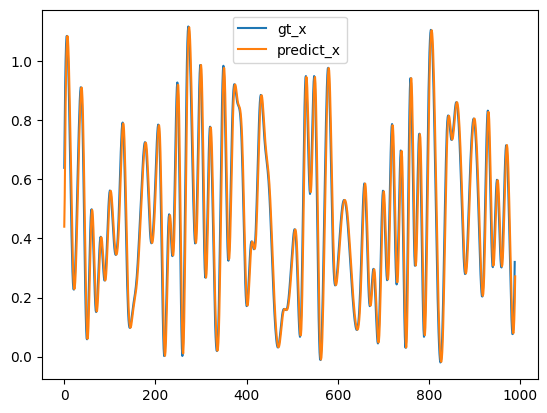

In [17]:
physics_dt = 1.0/100
rendering_dt = 1.0/10
create_new_stage()
init_pos = data['init_pos']
init_rot = data['init_rot']
init_vel = data['init_vel'] # doesn't matter
world = World(physics_dt=physics_dt, rendering_dt=rendering_dt)
cube = DynamicCuboid('/cube', 'cube0', translation=init_pos, orientation=init_rot)
cube.prim.GetAttribute('physics:kinematicEnabled').Set(True)
imu = IMU('/cube/imu', 'imu0')
world.scene.add(cube)
world.scene.add(imu)

world.reset()
g = world.get_physics_context().get_gravity()[1]
imu_gyro = []
imu_accel = []
imu_orient = []
gt_pos = data['gt_pos']
gt_orient = data['gt_rot']
playing = True

pose_iter = iter(zip(gt_pos, gt_orient))

def set_pose(step_size):
    global playing
    try:
        pos, orient = next(pose_iter)
        cube.prim.GetAttribute('xformOp:translate').Set(Gf.Vec3d(*pos))
        cube.prim.GetAttribute('xformOp:orient').Set(Gf.Quatd(*orient))
    except StopIteration:
        playing = False

def save_imu(step_size):
    frame = imu.get_current_frame()
    imu_gyro.append(frame['gyro'])
    imu_accel.append(frame['accel'])
    imu_orient.append(frame['orientation'])
        
world.add_physics_callback("set_pose", set_pose)
world.add_physics_callback("save_imu", save_imu)

while playing:
    world.step()

world.stop()

g = world.get_physics_context().get_gravity()[1]
init_state = {
    'pos':torch.Tensor(translations[0]), 
    'rot':pp.SO3(quats_xyzw[0]), 
    'vel':torch.Tensor(velocities[0])
}

integrator = pp.module.IMUPreintegrator(
    **init_state,
    gravity=g,
    gyro_cov=0.0,
    acc_cov=0.0
)

predict_state = integrator(
    dt = torch.Tensor(np.array([physics_dt]*len(imu_gyro))).unsqueeze(1),
    gyro = torch.Tensor(imu_gyro),
    acc = torch.Tensor(imu_accel),
)

predict_pos = predict_state['pos'][0].numpy()
N = len(predict_pos)
plt.plot(gt_pos[:N, 0], label='gt_x')
plt.plot(predict_pos[:N, 0], label='predict_x')
plt.legend()

